<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 5</h1>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe, hp, fmin, Trials, rand
from tensorflow.keras import layers, activations
from itertools import combinations_with_replacement

from keras.layers import Input, Flatten, Dense

2025-06-25 12:46:04.585607: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 12:46:04.632763: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-25 12:46:04.722766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750848364.902148    6493 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750848364.953193    6493 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750848365.640076    6493 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

<h1 style="color: blue; font-size:50px;"> Esercizio 1 - Ottimizzazione Bayesana</h1>

L’ottimizzazione bayesiana è una tecnica di ottimizzazione usata per trovare il massimo (o minimo) di una funzione obiettivo costosa da valutare e senza una forma analitica nota, cioè una black-box function. Per svolgere questo esercizio verrà utilizzata la libreria **Hyperopt**, pensata per l'ottimizzazione automatica di funzioni.

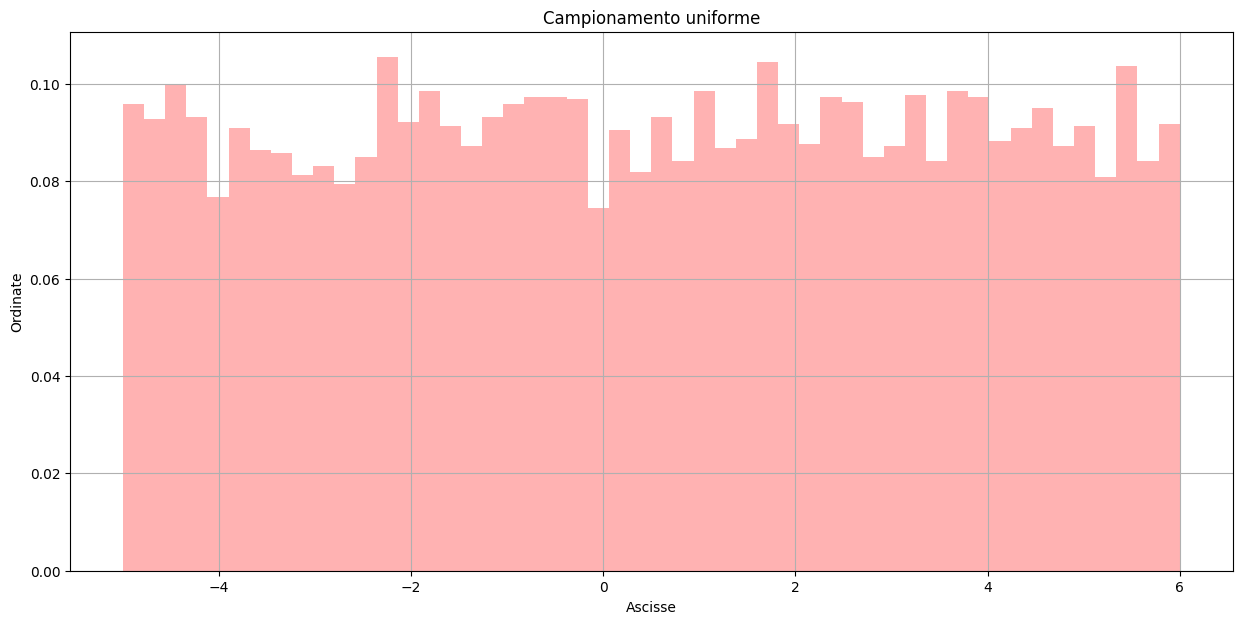

100%|██████████| 2000/2000 [00:34<00:00, 58.24trial/s, best loss: -219.80120225483725]
Miglior valore dell'iperparametro:  4.8782481045528225


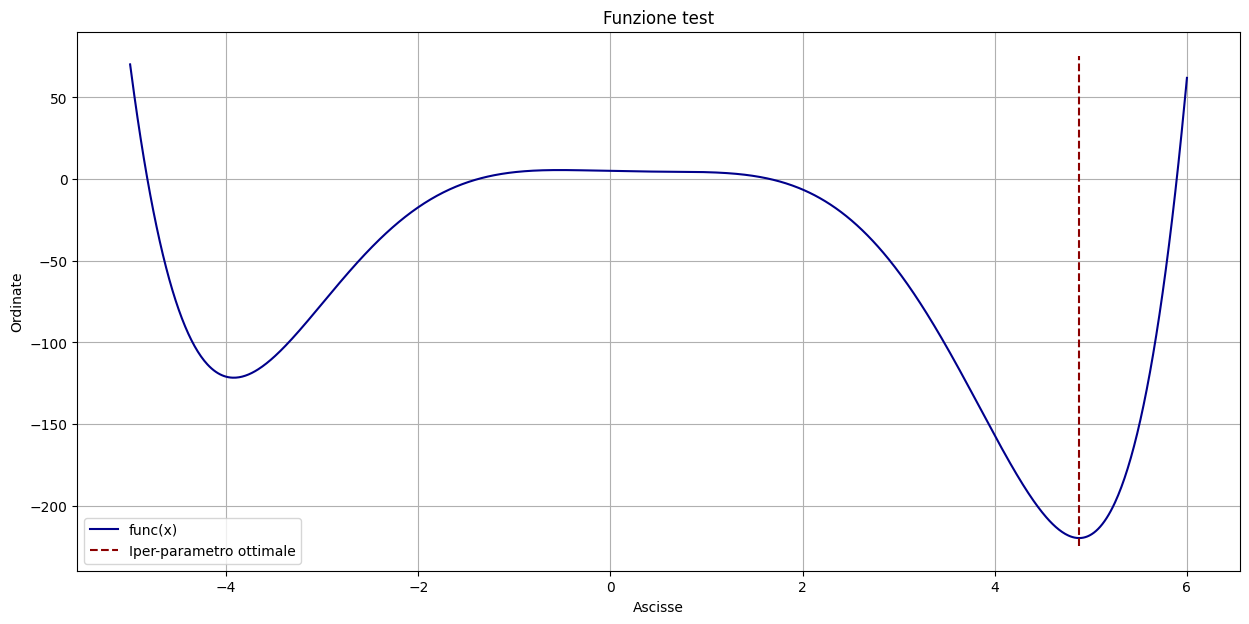

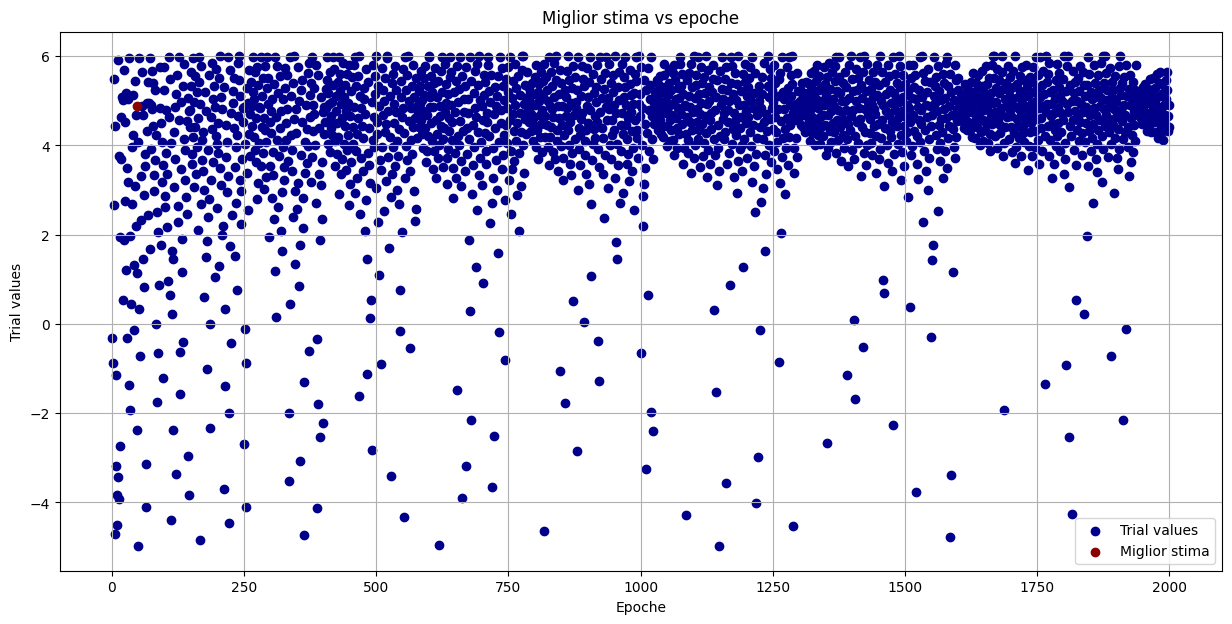

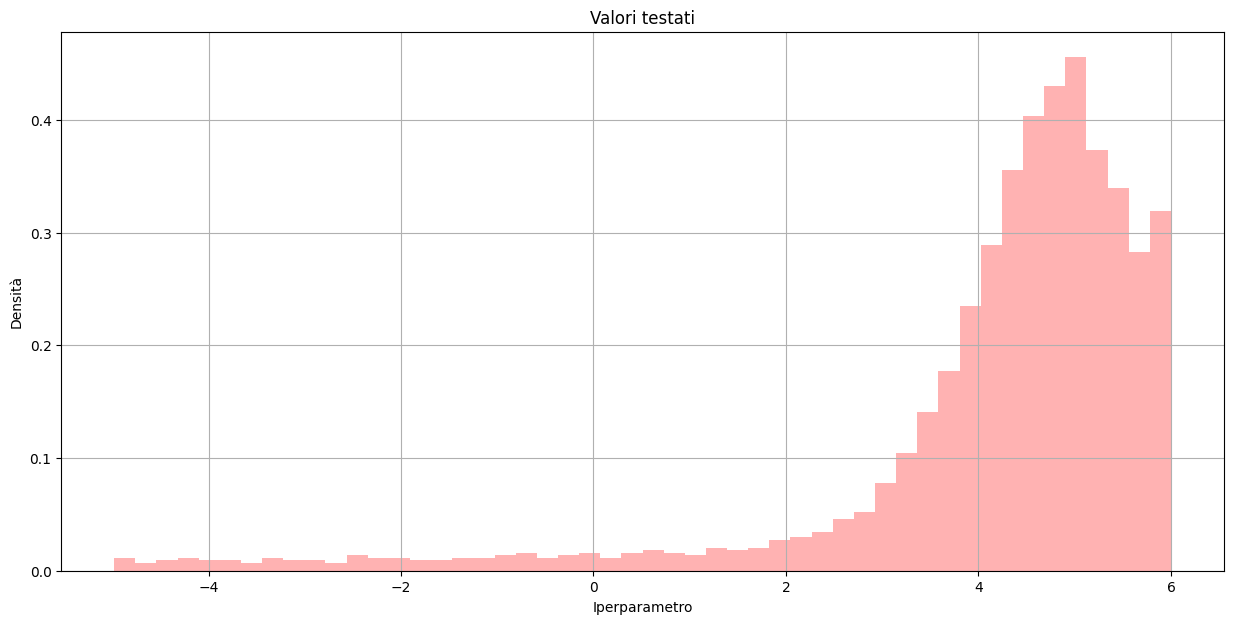

In [2]:
def func(x):
    # Polinomio f(x) = 0.05 * (x^6 - 2x^5 - 28x^4 + 28x^3 + 12x^2 - 26x + 100)
    p = np.poly1d([1, -2, -28, 28, 12, -26, 100])
    return p(x) * 0.05

def plotF(x, minV):
    # Funzione per plottare target

    y = func(x)         # Calcolo funzione
    fig = plt.figure(figsize = (15, 7))
    plt.plot(x, y, color = 'darkblue', label = "func(x)")
    plt.plot(np.array([minV, minV]), np.array([min(y)-5, max(y)+5]), color = 'darkred', linestyle = '--', label = "Iper-parametro ottimale")
    plt.title("Funzione test")
    plt.ylabel("Ordinate")
    plt.xlabel("Ascisse")
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()

def plotUnif(x, nbins):
    # Funzione per plottare campionamento uniforme
    fig = plt.figure(figsize = (15, 7))
    plt.hist(x, bins = nbins, range = (min(x), max(x)), density = True, color = (1, 0, 0, 0.3))
    plt.title("Campionamento uniforme")
    plt.ylabel("Ordinate")
    plt.xlabel("Ascisse")
    plt.grid(True)
    plt.show()


def plotHypTr(trials, minV):
    # Funzione per plottare trials vs epoche
    fig = plt.figure(figsize = (15, 7))
    plt.scatter(np.linspace(1, 2000, 2000), np.array(trials.vals['x']), color = 'darkblue', label = 'Trial values')
    plt.scatter(np.array([np.argmin(np.array(trials.vals['x']))]), np.array(minV['x']), color = 'darkred', label = 'Miglior stima')

    plt.title("Miglior stima vs epoche")
    plt.ylabel("Trial values")
    plt.xlabel("Epoche")

    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()


def plotSearch(trials, nbins):
    # Funzione per plottare istogramma ricerca minimo
    fig = plt.figure(figsize = (15, 7))
    plt.hist(np.array(trials.vals['x']), bins = nbins, color = (1, 0, 0, 0.3), density=True)

    plt.title("Valori testati")
    plt.xlabel("Iperparametro")
    plt.ylabel("Densità")

    plt.grid(True)
    plt.show()


# Definiamo ora un dominio di ricerca uniforme utilizzando hyperopt
# Facciamo sampling di questo dominio e facciamo un istogramma
space = hp.uniform('x', -5, 6)
plotUnif([sample(space) for _ in range(10000)], 50)


# Procediamo con la minimizzazione della funzione obiettivo, ossia func(x), utilizzando il modello TPE. Le 
# valutazioni della funzione stessa sono 2000. Utilizzo Trials per tenere memoria dell'evoluzione dei vari 
# parametri nelle fasi di allenamento del modello
trials = Trials()
minV = fmin(
    fn=func,                # Funzione obiettivo da ottimizzare
    space=space,            # Spazio dell'iperparametro, in cui sarà cercato il valore ottimale
    algo=tpe.suggest,       # Algoritmo di ottimizzazione
    max_evals=2000,         # Tentativi di ottimizzazione della funzione
    trials = trials         # Memorizzazione fasi ottimizzazione
)
print("Miglior valore dell'iperparametro: ", minV['x'])


# Valuto funzione polinomiale su un intervallo di punti equispaziati fra [-5, 6]
# Evidenzio come la previsione dell'ottimizzazione coincida effettivamente con il minimo della funzione
x = np.linspace(-5, 6, 1000)
plotF(x, minV['x'])


# Stampo ora scatterplot e istogramma per analisi più dettagliate su metodologia ricerca minimo
plotHypTr(trials, minV)
plotSearch(trials, 50)

100%|██████████| 2000/2000 [00:09<00:00, 203.79trial/s, best loss: -219.79005138679477]
Miglior valore dell'iperparametro:  4.868840998980232


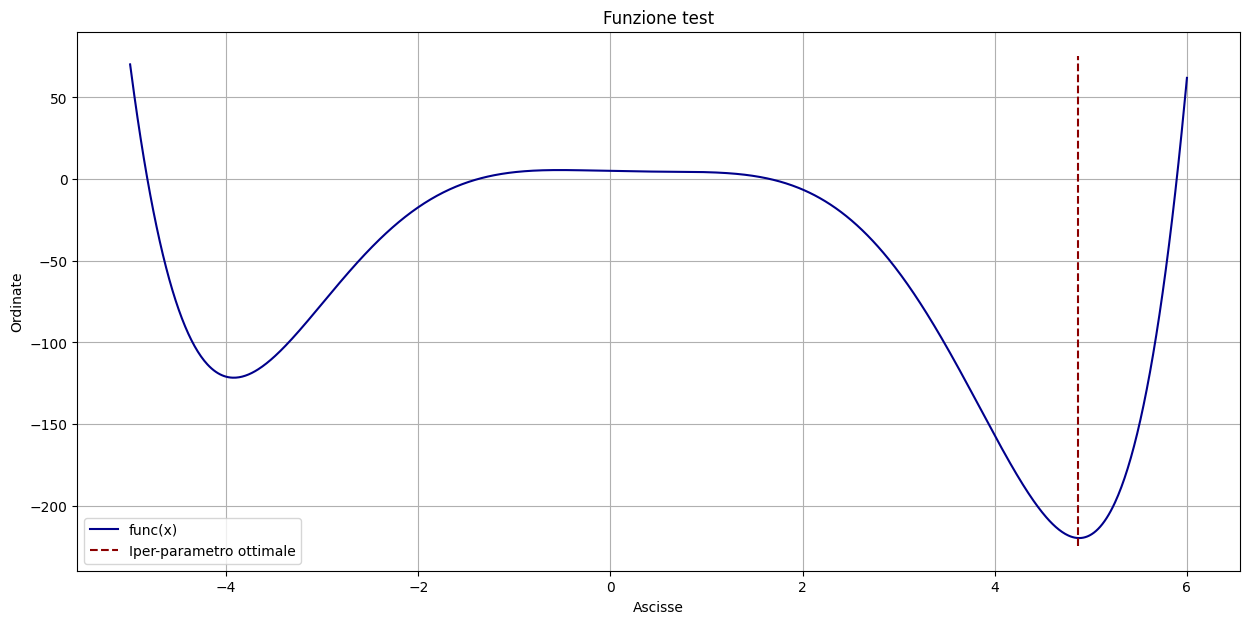

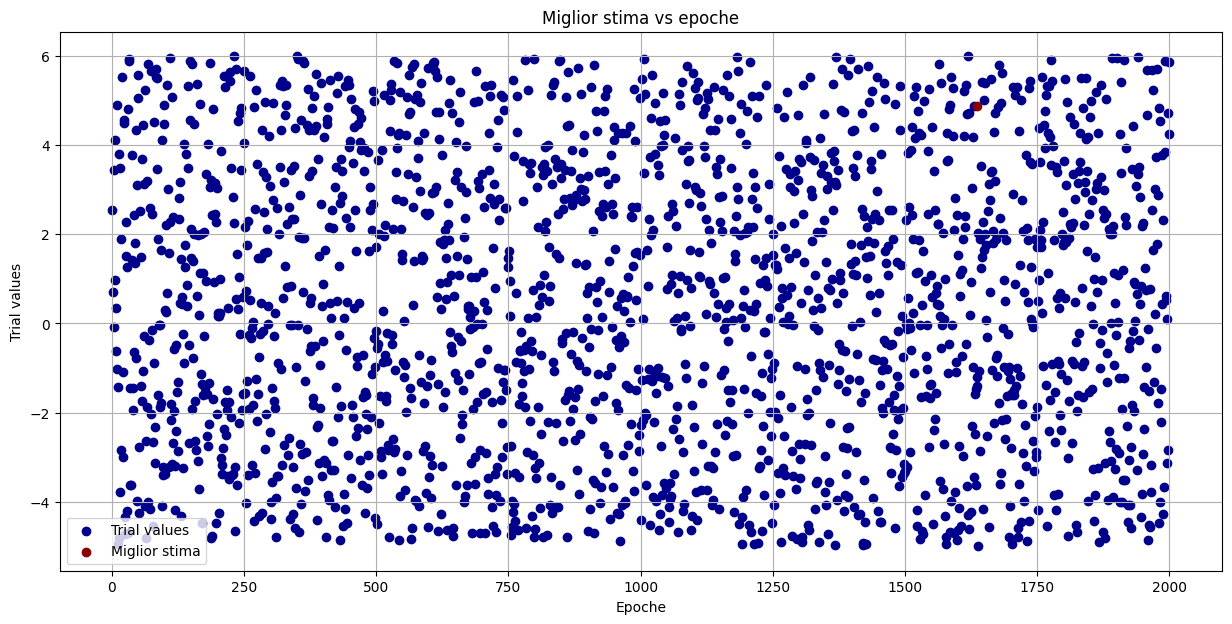

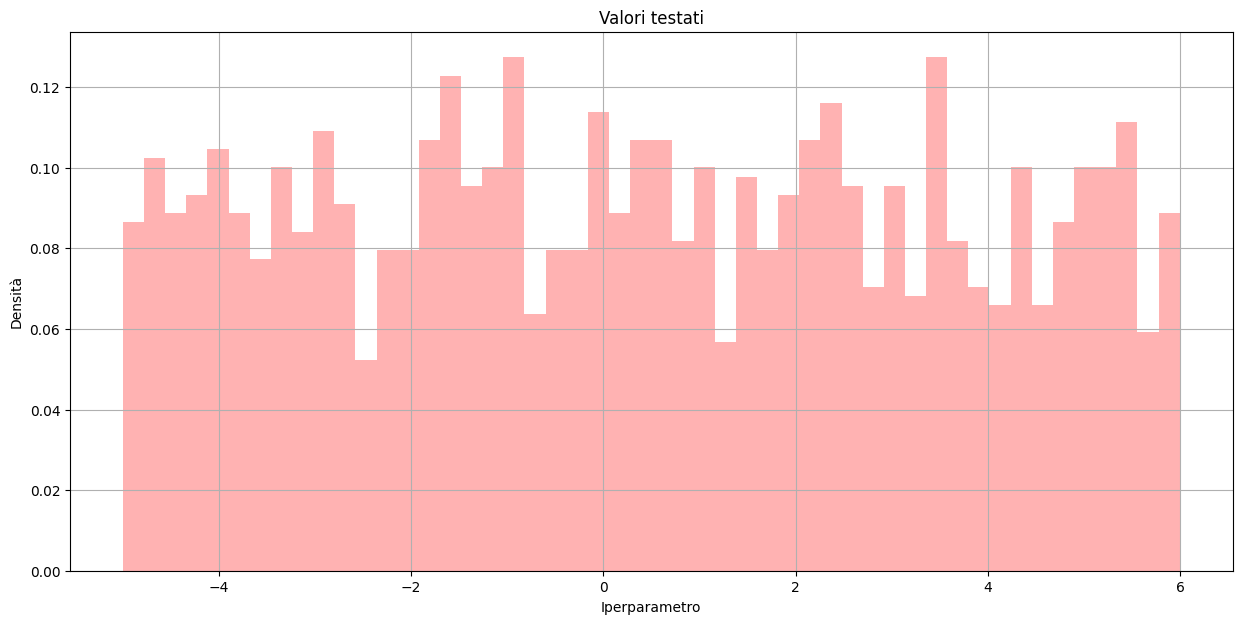

In [3]:
# Rifaccio quanto ho appena fatto sopra, ma utilizzando un algoritmo di ricerca stocastico
def func(x):
    # Polinomio f(x) = 0.05 * (x^6 - 2x^5 - 28x^4 + 28x^3 + 12x^2 - 26x + 100)
    p = np.poly1d([1, -2, -28, 28, 12, -26, 100])
    return p(x) * 0.05

def plotF(x, minV):
    # Funzione per plottare target

    y = func(x)         # Calcolo funzione
    fig = plt.figure(figsize = (15, 7))
    plt.plot(x, y, color = 'darkblue', label = "func(x)")
    plt.plot(np.array([minV, minV]), np.array([min(y)-5, max(y)+5]), color = 'darkred', linestyle = '--', label = "Iper-parametro ottimale")
    plt.title("Funzione test")
    plt.ylabel("Ordinate")
    plt.xlabel("Ascisse")
    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()

def plotUnif(x, nbins):
    # Funzione per plottare campionamento uniforme
    fig = plt.figure(figsize = (15, 7))
    plt.hist(x, bins = nbins, range = (min(x), max(x)), density = True, color = (1, 0, 0, 0.3))
    plt.title("Campionamento uniforme")
    plt.ylabel("Ordinate")
    plt.xlabel("Ascisse")
    plt.grid(True)
    plt.show()


def plotHypTr(trials, minV):
    # Funzione per plottare trials vs epoche
    fig = plt.figure(figsize = (15, 7))
    plt.scatter(np.linspace(1, 2000, 2000), np.array(trials.vals['x']), color = 'darkblue', label = 'Trial values')
    plt.scatter(np.array([np.argmin(np.array(trials.vals['x']))]), np.array(minV['x']), color = 'darkred', label = 'Miglior stima')

    plt.title("Miglior stima vs epoche")
    plt.ylabel("Trial values")
    plt.xlabel("Epoche")

    plt.legend(loc = 'best')
    plt.grid(True)
    plt.show()


def plotSearch(trials, nbins):
    # Funzione per plottare istogramma ricerca minimo
    fig = plt.figure(figsize = (15, 7))
    plt.hist(np.array(trials.vals['x']), bins = nbins, color = (1, 0, 0, 0.3), density=True)

    plt.title("Valori testati")
    plt.xlabel("Iperparametro")
    plt.ylabel("Densità")

    plt.grid(True)
    plt.show()


# Procediamo con la minimizzazione della funzione obiettivo, ossia func(x), utilizzando algoritmo stocastico. Le 
# valutazioni della funzione stessa sono 2000. Utilizzo Trials per tenere memoria dell'evoluzione dei vari 
# parametri nelle fasi di allenamento del modello
trials = Trials()
minV = fmin(
    fn=func,                # Funzione obiettivo da ottimizzare
    space=space,            # Spazio dell'iperparametro, in cui sarà cercato il valore ottimale
    algo=rand.suggest,      # Algoritmo di ottimizzazione stocastico
    max_evals=2000,         # Tentativi di ottimizzazione della funzione
    trials = trials         # Memorizzazione fasi ottimizzazione
)
print("Miglior valore dell'iperparametro: ", minV['x'])


# Valuto funzione polinomiale su un intervallo di punti equispaziati fra [-5, 6]
# Evidenzio come la previsione dell'ottimizzazione coincida effettivamente con il minimo della funzione
x = np.linspace(-5, 6, 1000)
plotF(x, minV['x'])


# Stampo ora scatterplot e istogramma per analisi più dettagliate su metodologia ricerca minimo
plotHypTr(trials, minV)
plotSearch(trials, 50)

<h1 style="color: blue; font-size:50px;"> Esercizio 2 - Hyperparameter scan</h1>

L'obiettivo di questo esercizio è la scrittura di una procedura di iper-ottimizzazione che consenta di determinare quale sia la rete neurale ottimale per classificare delle immagini di numeri. Sebbene vengano utilizzate delle funzionalità di **hyperopt** per la risoluzione degli esercizi, sarebbe anche possibile effettuare uno studio manuale per mezzo della funzione qui presente. 

```python
# Funzione per iperottimizzazione del modello. Siamo interessati a studiare quale sia il 
# numero di layer ottimale, il numero di nodi ottimale ed il learning rate ottimale
def hyperMod(paramSpace):
    # Funzione per iperottimizzazione del modello     
         
    hist = []
    for i in paramSpace['nlayers']:
        for j in combinations_with_replacement(paramSpace['nnodes'], i):
            # Creo modello con numero di layer e nodi specificato dall'esterno
            model = buildMod(i, list(j))

            for l in paramSpace['lrate']:
                # Faccio un ciclo sui diversi learning rate
                model.compile(
                    optimizer=tf.keras.optimizers.Adam(learning_rate=l), 
                    loss='sparse_categorical_crossentropy', metrics=['accuracy']
                )
                model.fit(imTr, labTr, epochs = 5, validation_data=(imVal, labVal)) 
                hist += model.history.history
    
    return hist

paramSpace = {
    'nlayers': [1, 2],
    'nnodes': [32, 64, 128],
    'lrate': [0.01, 0.05, 0.1]
}

# Iperottimizzazione del modello
hyperMod(paramSpace)
```

Dimensioni del training set: (60000, 28, 28)
Dimensioni del validation set: (10000, 28, 28)


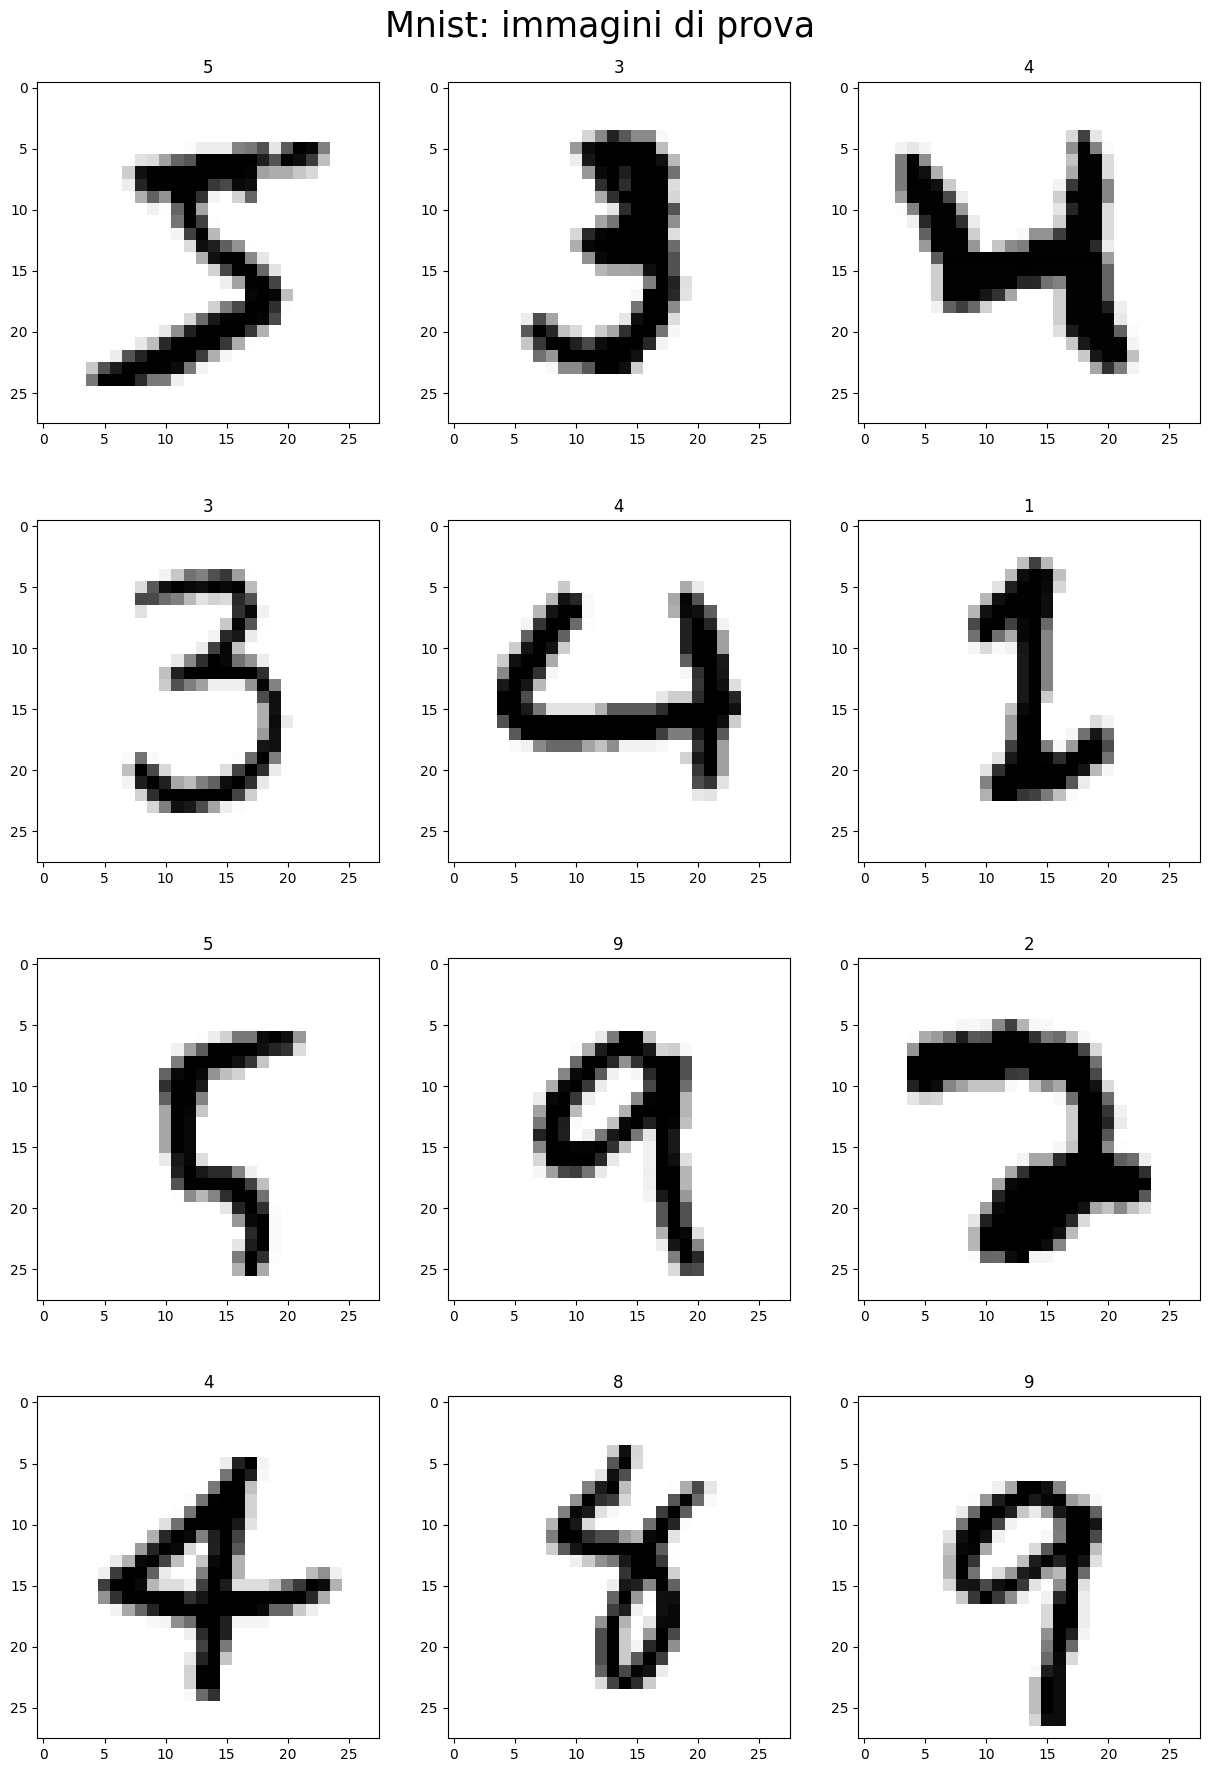

2025-06-25 12:47:34.934559: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/5


2025-06-25 12:47:35.924969: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1868/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8798 - loss: 0.4186

2025-06-25 12:47:48.486827: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8800 - loss: 0.4179 - val_accuracy: 0.9552 - val_loss: 0.1463
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9631 - loss: 0.1272 - val_accuracy: 0.9693 - val_loss: 0.0970
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9774 - loss: 0.0770 - val_accuracy: 0.9740 - val_loss: 0.0828
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9818 - loss: 0.0597 - val_accuracy: 0.9775 - val_loss: 0.0777
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.9868 - loss: 0.0442 - val_accuracy: 0.9758 - val_loss: 0.0748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━

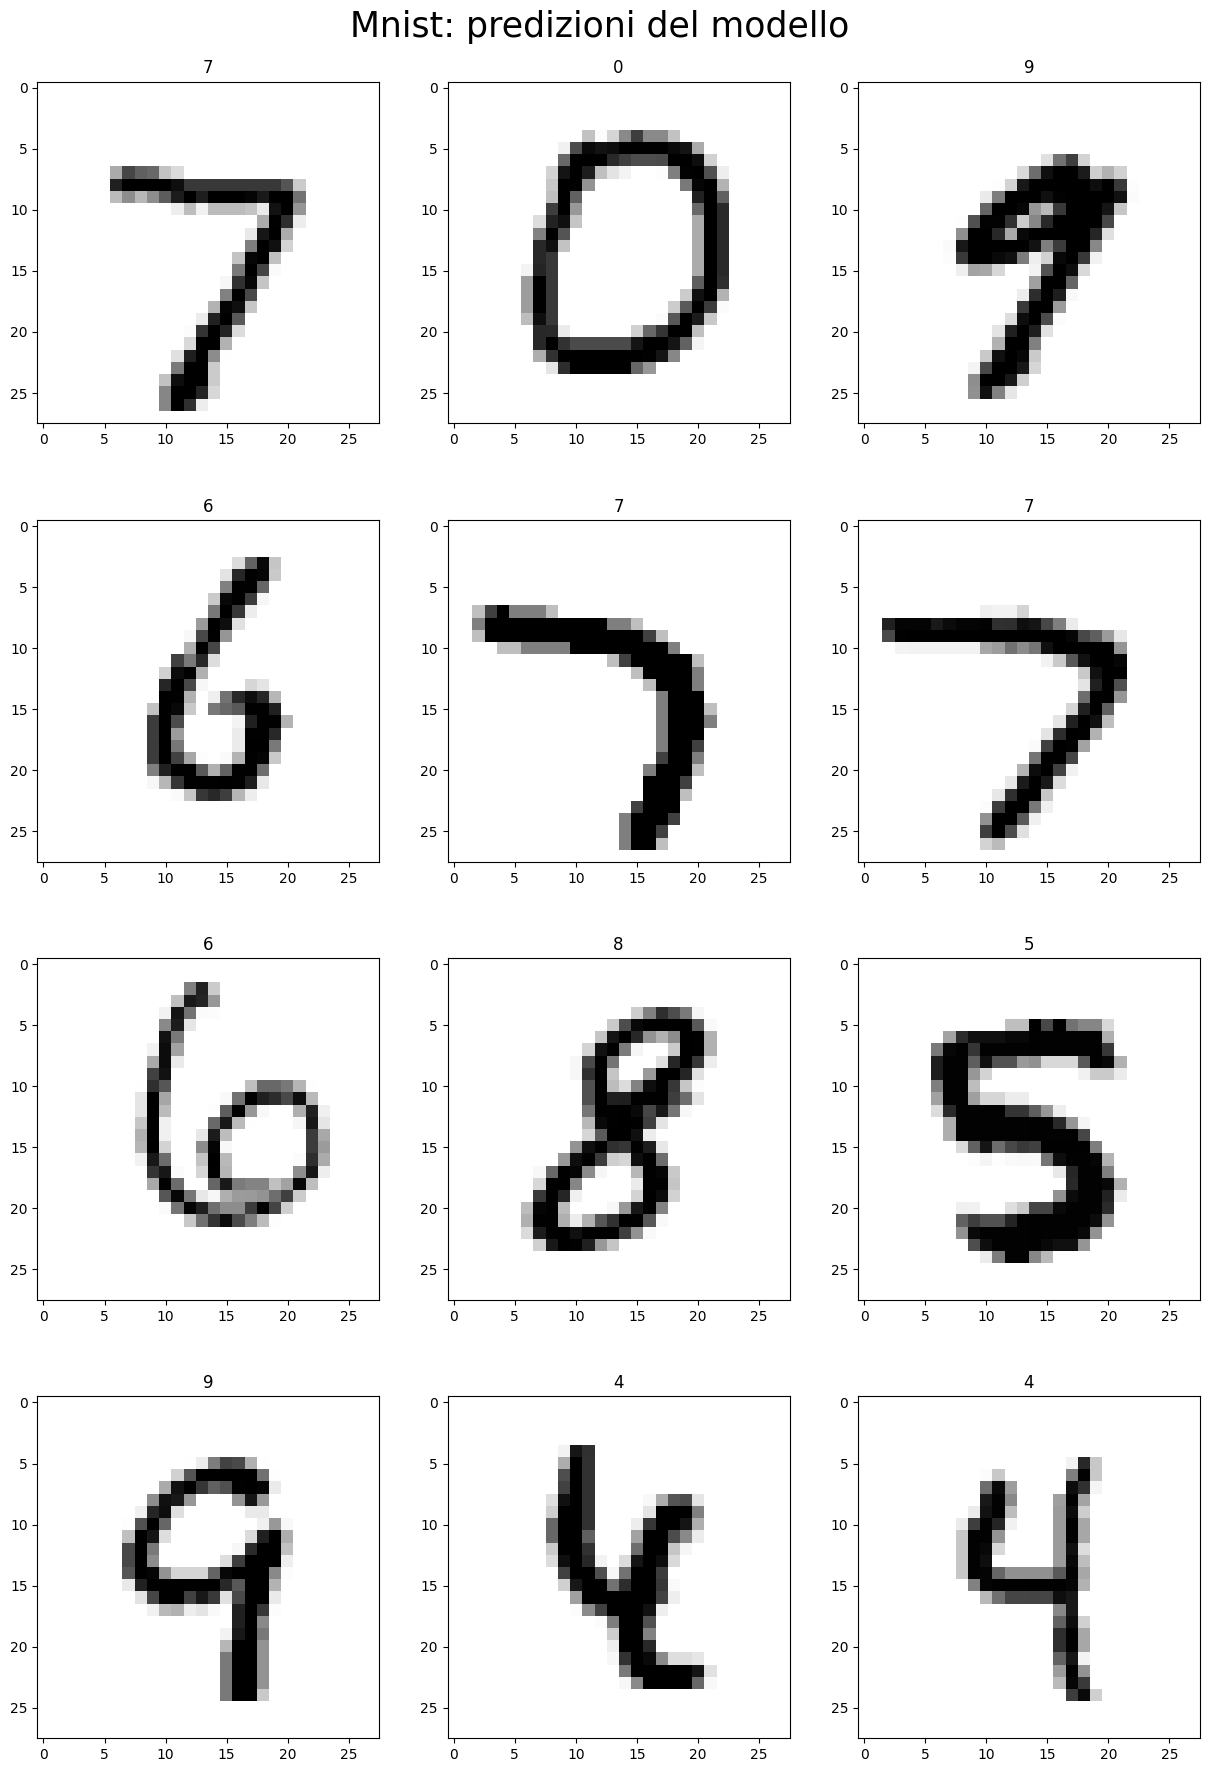

In [4]:
def printImg(img, label, title):
    # Funzione per stampa immagini di prova
    fig, ax = plt.subplots(4, 3, figsize = (15, 20))
    for i in range(0, 4):
        for j in range(0, 3):
            ax[i][j].imshow(img[50*i+10*j], cmap = 'binary')
            ax[i][j].set_title(str(label[50*i+10*j]))

    fig.suptitle(title, fontsize = 25)
    plt.subplots_adjust(top=0.95)
    plt.show()


def printPred(model, img, title):
    # Funzione per stampa predizioni
    fig, ax = plt.subplots(4, 3, figsize = (15, 20))
    for i in range(0, 4):
        for j in range(0, 3):
            ax[i][j].imshow(img[50*i+10*j], cmap = 'binary')
            ax[i][j].set_title(str(np.argmax(model.predict(np.expand_dims(img[50*i + 10*j], axis=0)))))

    fig.suptitle(title, fontsize = 25)
    plt.subplots_adjust(top=0.95)
    plt.show()


def buildMod(nlayers, nnodes):
    # Funzione per creare rete neurale. Come prima cosa controllo se 
    # l'input è adeguato (per ogni layer sto specificando correttamente il 
    # numero di nodi che lo costituiscono)
    if nlayers != len(np.array(nnodes)):
        raise ValueError("Numero di layer e numero di nodi per layer specificati non vanno bene. Occhio a lunghezza nnodes!")
    elif nlayers <= 0:
        raise ValueError("Numero di layer nascosti minore o uguale a zero!")
    else:
        model = keras.Sequential()
        
        model.add(Input(shape=(28, 28)))
        model.add(Flatten())                        # Layer di flattening
        
        for i in range(0, nlayers):
            model.add(keras.layers.Dense(nnodes[i], activation='relu'))
        model.add(keras.layers.Dense(10, activation='softmax'))
        
        return model


# Il primo step consiste nel caricare il dataset mnist, del quale valutiamo le dimensioni 
# e che normalizziamo in modo tale da avere pixel al più unitari
from keras.datasets import mnist
(imTr, labTr), (imVal, labVal) = mnist.load_data()

#Studio dimensioni
print("Dimensioni del training set:", imTr.shape)
print("Dimensioni del validation set:", imVal.shape)

# Normalizzazione immagini (e stampa immagini prova)
imVal = imVal/imVal.max()
imTr = imTr/imTr.max()
printImg(imTr, labTr, "Mnist: immagini di prova")


# Creazione del modello, che presenta un numero di layer nascosti maggiore o uguale ad uno, 
# e numero di nodi per layer specificati dall'utente in fase di inzializzazione dello stesso
model = buildMod(1, [128])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(imTr, labTr, epochs = 5, validation_data=(imVal, labVal)) 
printPred(model, imVal, "Mnist: predizioni del modello")

In [ ]:
# Funzione per iperottimizzazione del modello. Siamo interessati a studiare quale sia il 
# numero di layer ottimale, il numero di nodi ottimale ed il learning rate ottimale
def hyperMod(imTr, labTr, imVal, labVal, paramSpace):
    # Funzione per iperottimizzazione del modello     
    l = paramSpace['lrate']
    n = paramSpace['nnodes']
    print(f"Modello con {n} nodi e learning rate {l}:\n")
         
    # Costruisco il modello con numero di nodi specificato dall'esterno (e anche learning rate)
    # Alleno il modello e la funzione ritorna 1 - accuracy, perchè voglio usare fmin
    model = buildMod(1, [n])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(imTr, labTr, epochs = 5, validation_data=(imVal, labVal), verbose=2) 
    print("\n\n")

    # Minimizzando questa quantità trovo la rete migliore
    return 1 - model.history.history['accuracy'][-1]


# Funzione obiettivo da minimizzare
def objective(params):
    return {
        'loss': hyperMod(imTr, labTr, imVal, labVal, params),
        'status': 'ok'  
    }

def lrate(x):
    # Funzione per recuperare il learning rate
    return x['misc']['vals']['lrate']


def accuracy(x):
    # Funzione per recuperare accuracy
    return x['result']['loss']


def nnodes(x):
    # Funzione per recuperare il numero di nodi
    return np.arange(10, 110, 20)[x['misc']['vals']['nnodes']]


def imgHyperOpt(trials):
    # Funzione per studiare andamento accuracy in spazio dei parametri
    lrVals =  list(map(lrate, trials.trials))
    accVals = list(map(accuracy, trials.trials))
    nodVals = list(map(nnodes, trials.trials))

    # Crea lo scatter 2D con colore basato su z
    fig, ax = plt.subplots(figsize=(15, 7))
    sc = ax.scatter(np.array(lrVals).ravel(), np.array(nodVals).ravel(), c=np.array(accVals).ravel(), cmap='viridis', s=80, edgecolor='k')

    # Etichette
    ax.set_xscale('log')
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Numero di Nodi")
    ax.set_title("Accuratezza in funzione dei parametri")

    # Barra dei colori
    cbar = plt.colorbar(sc)
    cbar.set_label("Accuracy")

    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

paramSpace = {
    'nnodes': hp.choice('nnodes', np.arange(10, 110, 20)),
    'lrate': hp.loguniform('lrate', -10, 0)
}

trials = Trials()
best = fmin(
    objective, 
    paramSpace, 
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)

imgHyperOpt(trials)

Modello con 10 nodi e learning rate 0.011922407423267079:

Epoch 1/5                                              

1875/1875 - 27s - 14ms/step - accuracy: 0.8807 - loss: 0.4087 - val_accuracy: 0.9060 - val_loss: 0.3271

Epoch 2/5                                              

1875/1875 - 21s - 11ms/step - accuracy: 0.9124 - loss: 0.3057 - val_accuracy: 0.9025 - val_loss: 0.3367

Epoch 3/5                                              

1875/1875 - 22s - 12ms/step - accuracy: 0.9171 - loss: 0.2916 - val_accuracy: 0.9277 - val_loss: 0.2571

Epoch 4/5                                              

1875/1875 - 7s - 4ms/step - accuracy: 0.9193 - loss: 0.2841 - val_accuracy: 0.9215 - val_loss: 0.2949

Epoch 5/5                                              

1875/1875 - 7s - 4ms/step - accuracy: 0.9218 - loss: 0.2779 - val_accuracy: 0.9184 - val_loss: 0.2940

Modello con 10 nodi e learning rate 4.666486576458575e-05:                          

Epoch 1/5                                        